In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
df = pd.read_csv("./cada-2018-09-25.csv")

In [4]:
df

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...
5,19870380,directeur de la caisse régionale d'assurance m...,Avis,1987,30/04/1987,[Voir avis],Affaires Sanitaires Et Sociales/Solidarités Et...,"Sécurité sociale, Conditions de travail",Défavorable/Secret,III,La commission d'accès aux documents administra...
6,19881774,directeur général des impôts,Avis,1988,24/11/1988,(voir avis),Finances Publiques Et Fiscalité/Contrôle Fisca...,NaN,Défavorable/Procédure,III,La commission d'accès aux documents administra...
7,19881993,ministre de l'intérieur,Avis,1988,22/12/1988,[Voir avis],"Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,"Défavorable/Abusive, Sans objet",III,La commission d'accès aux documents administra...
8,19890099,ministre de l'intérieur (direction de la logis...,Avis,1989,19/01/1989,"- instructions, circulaires et guides opérateu...","Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,Favorable,III,La commission d'accès aux documents administra...
9,19890845,ministre de la justice (direction de l'adminis...,Conseil,1989,18/05/1989,"- ""tableau de service"" du centre de détention ...","Travail Et Emploi/Emploi Public, Justice, Ordr...","Carrière, Lieux de détention",Défavorable/Sécurité publique,II,La commission d'accès aux documents administra...


In [5]:
df["Sens_reduced"] = df["Sens et motivation"].dropna().apply(lambda x: re.split("[/,]+", x)[0].strip())
df.Année = pd.to_numeric(df.Année)


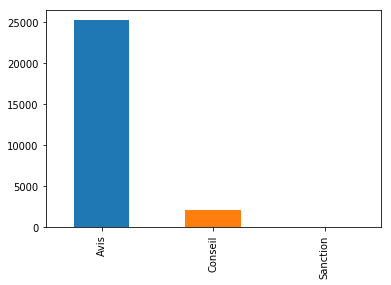

In [6]:
df.Type.value_counts().plot(kind="bar")
#print()
#print(df.Administration.value_counts())

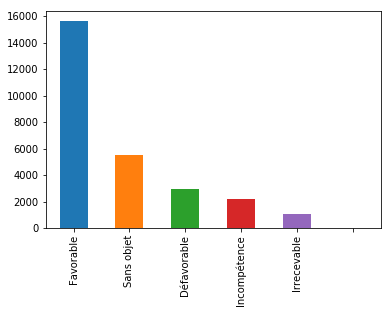

In [7]:
df.Sens_reduced.value_counts().plot(kind="bar")

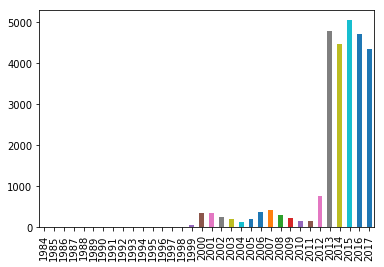

In [8]:
#df.Année.value_counts().plot(kind="bar")
df.Année.value_counts().sort_index().plot(kind="bar")


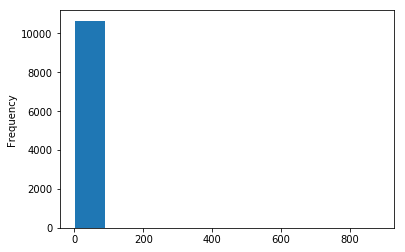

In [9]:
admin = df.Administration.dropna().value_counts()
admin.plot("hist")
# Most administrations requested by the CADA receive only one or two petitions

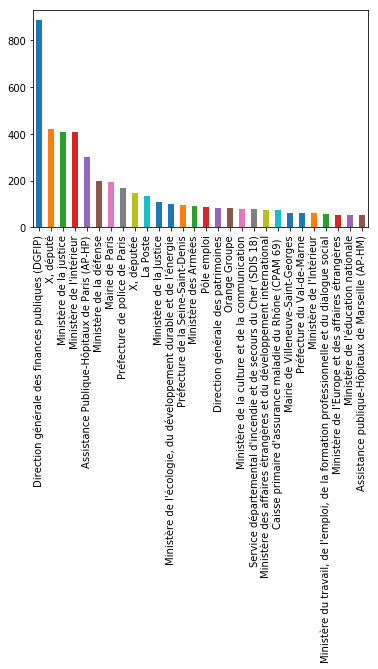

In [17]:
admin[admin > 50].plot(kind="bar")
sup_50 = admin[admin > 50].index

/home/pavel/anaconda3/envs/cada/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Administration                                                                            Sens_reduced
Assistance Publique-Hôpitaux de Paris (AP-HP)                                             Défavorable     AxesSubplot(0.125,0.125;0.775x0.755)
                                                                                          Favorable       AxesSubplot(0.125,0.125;0.775x0.755)
                                                                                          Incompétence    AxesSubplot(0.125,0.125;0.775x0.755)
                                                                                          Irrecevable     AxesSubplot(0.125,0.125;0.775x0.755)
                                                                                          Sans objet      AxesSubplot(0.125,0.125;0.775x0.755)
Assistance publique-Hôpitaux de Marseille (AP-HM)                                         Défavorable     AxesSubplot(0.125,0.125;0.775x0.755)
                                       

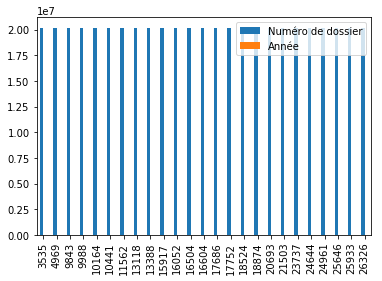

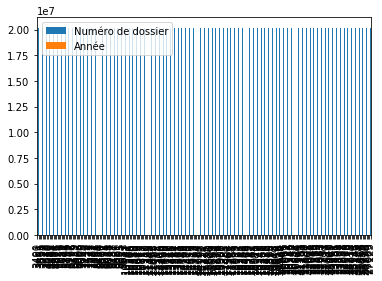

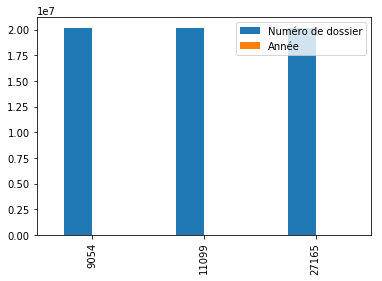

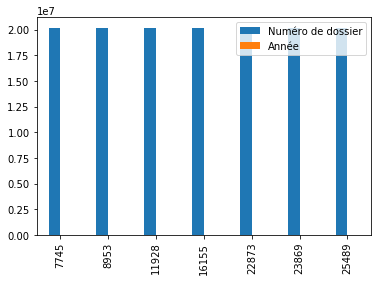

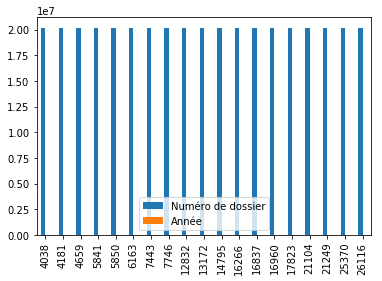

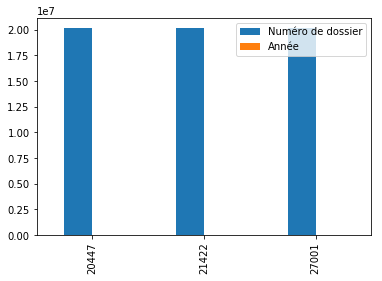

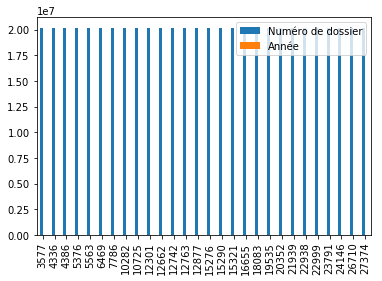

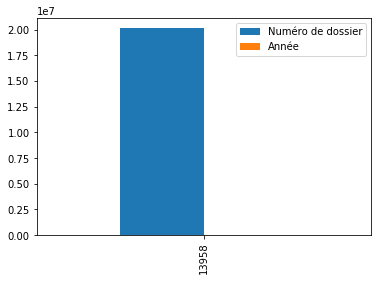

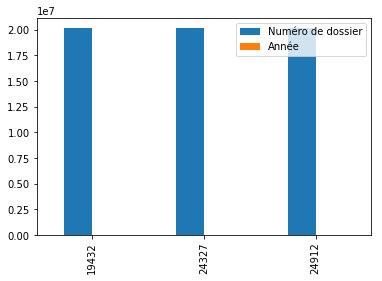

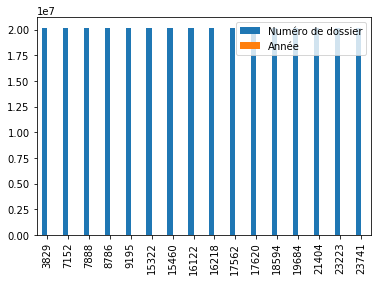

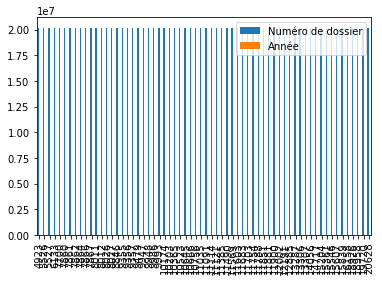

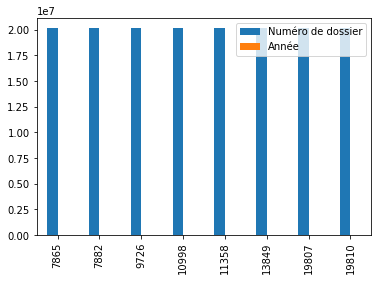

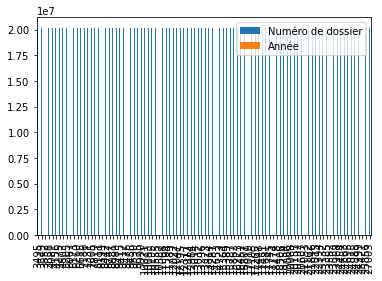

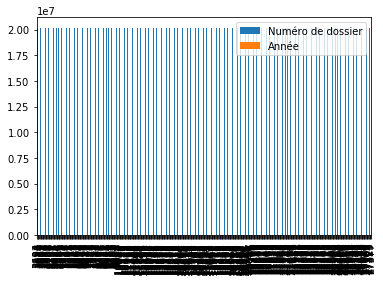

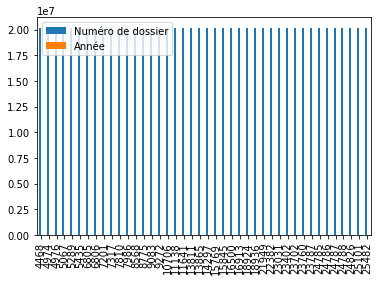

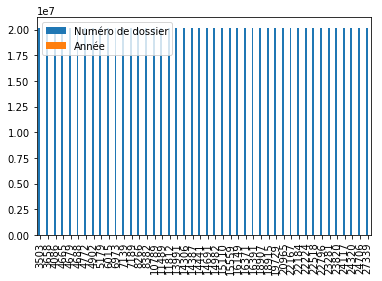

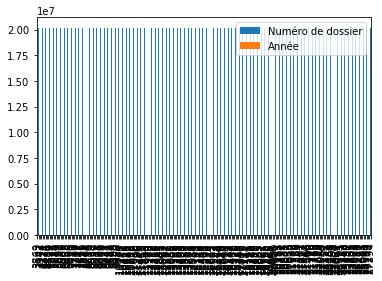

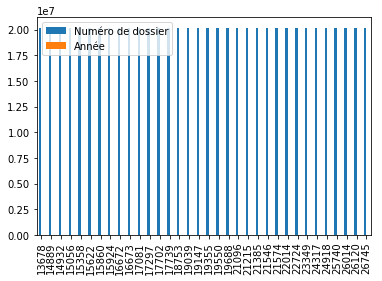

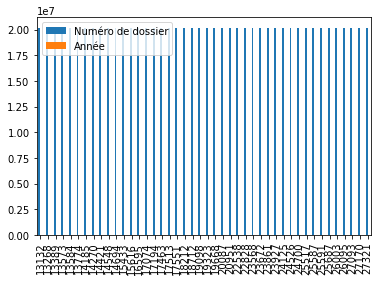

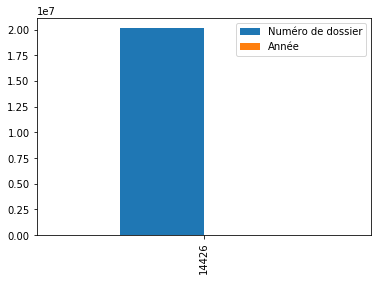

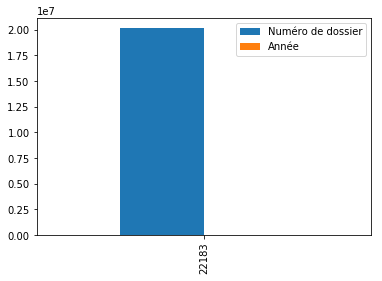

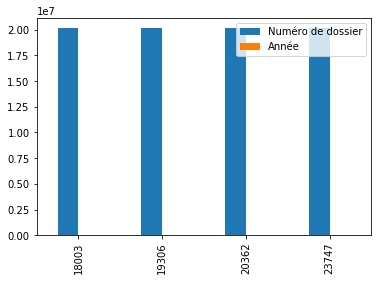

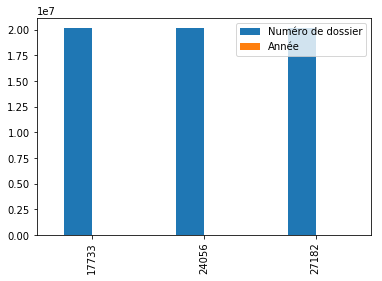

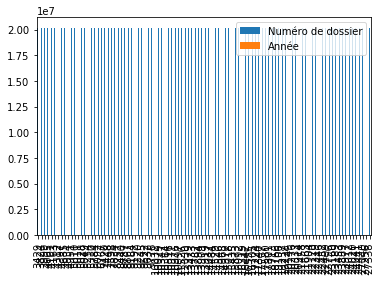

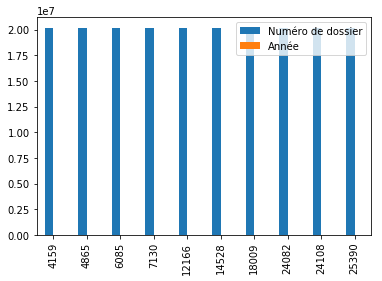

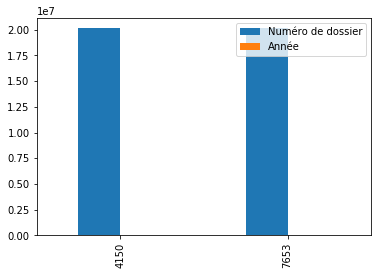

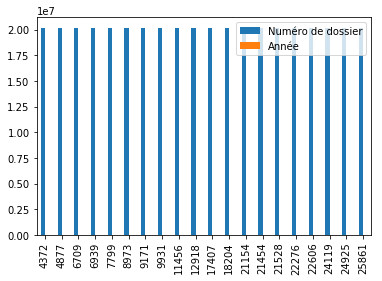

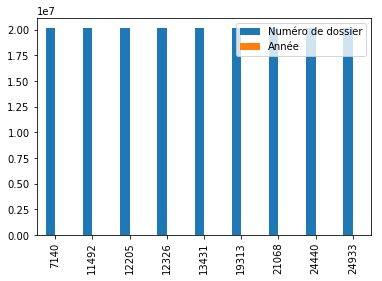

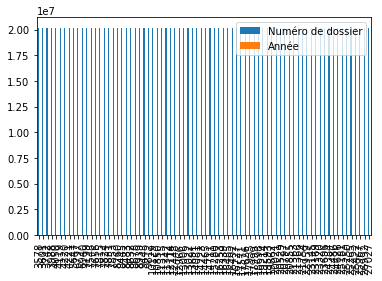

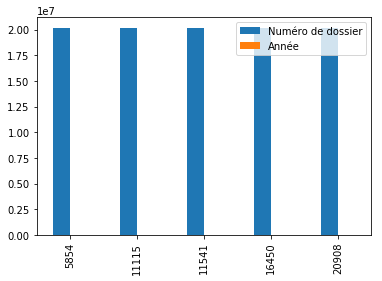

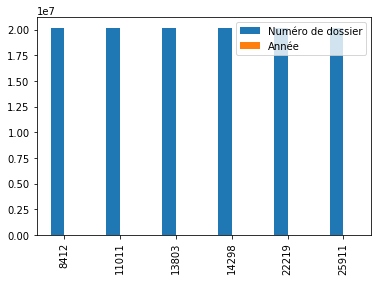

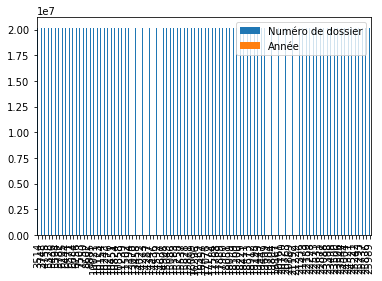

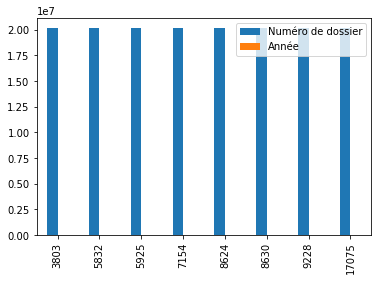

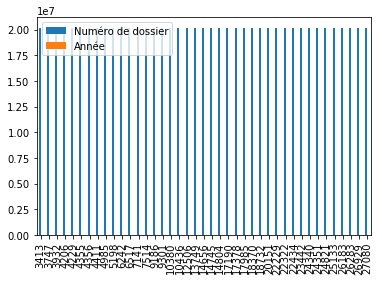

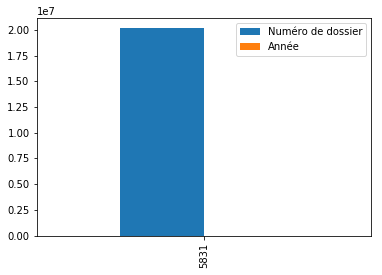

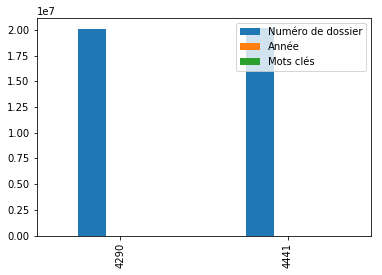

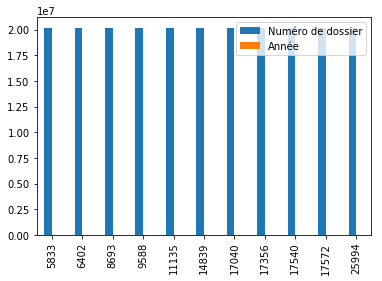

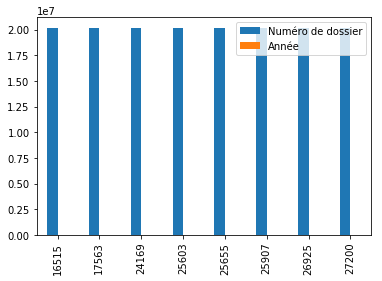

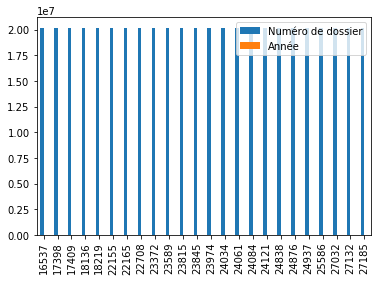

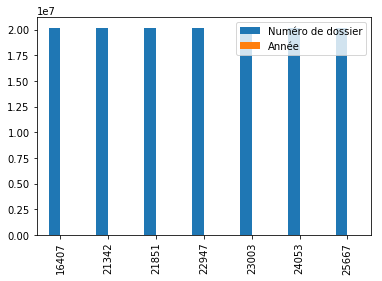

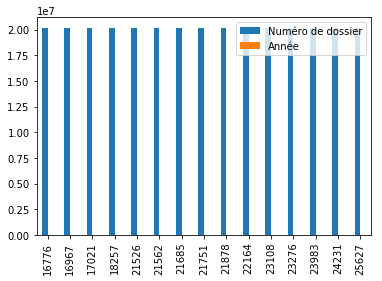

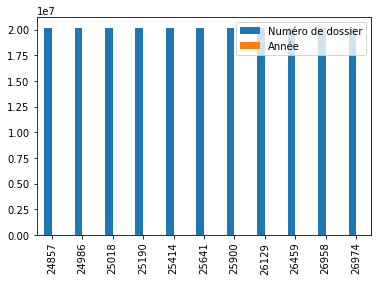

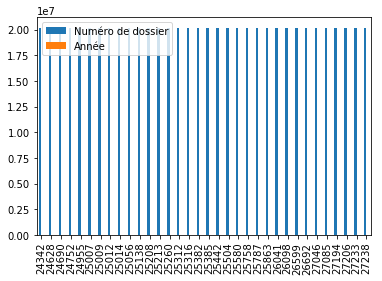

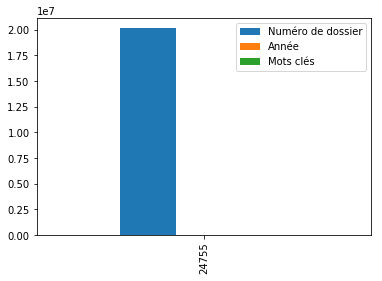

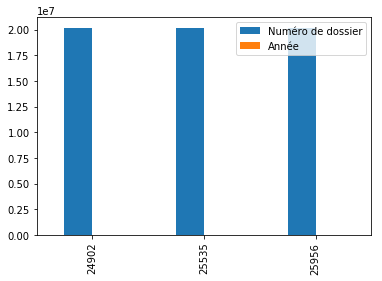

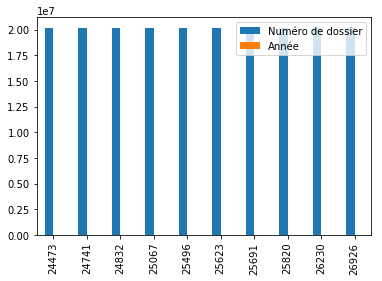

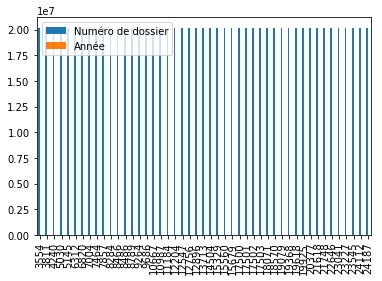

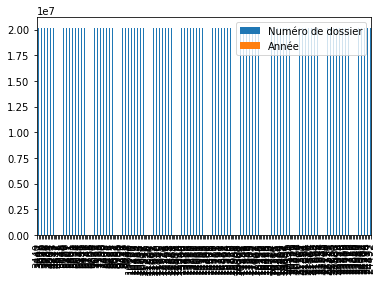

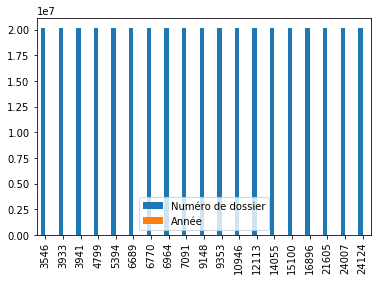

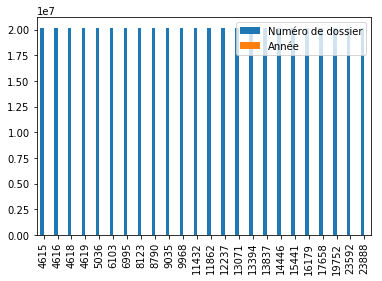

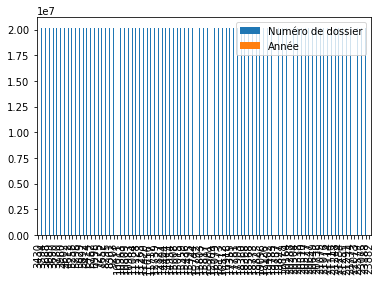

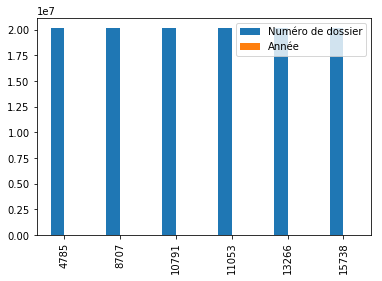

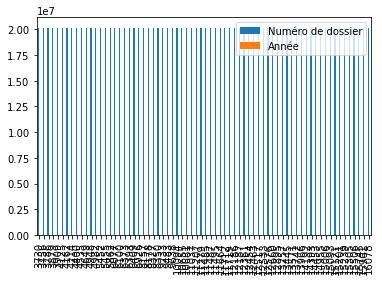

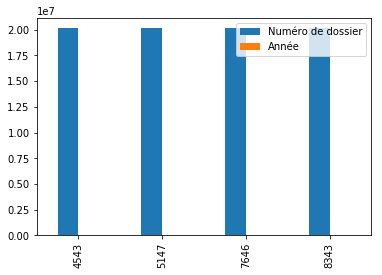

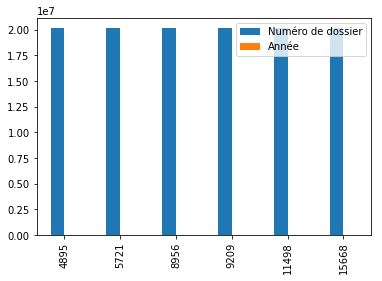

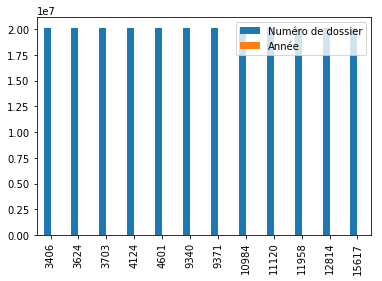

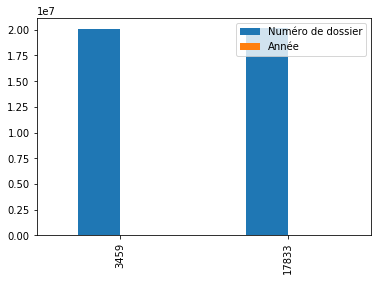

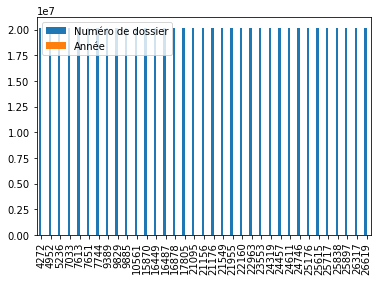

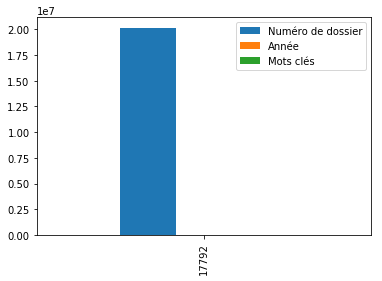

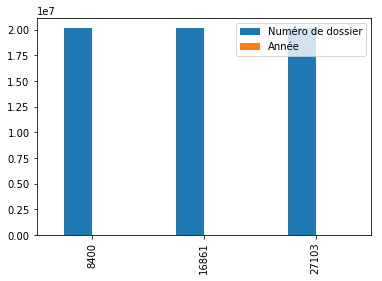

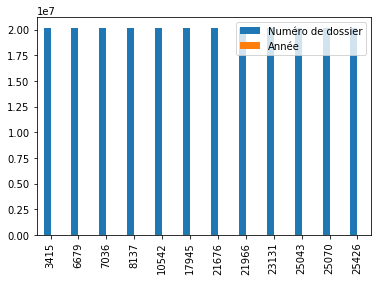

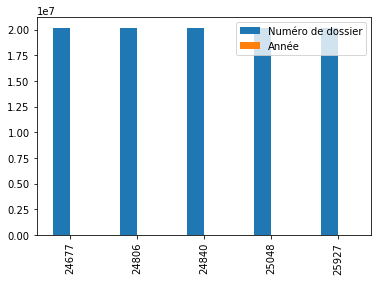

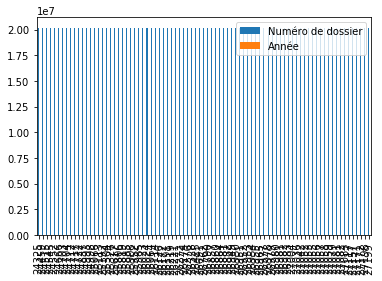

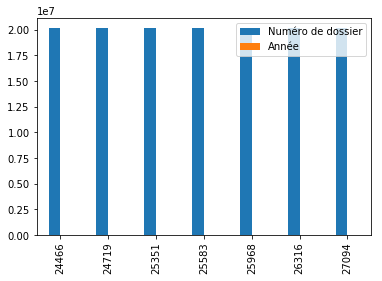

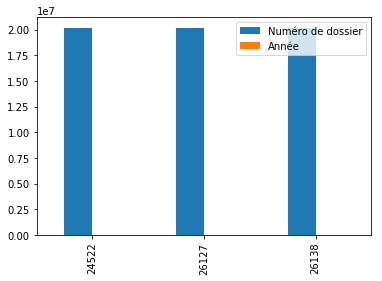

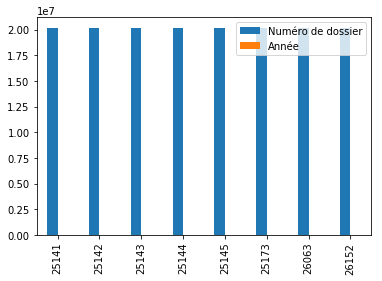

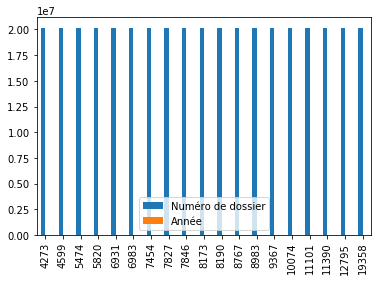

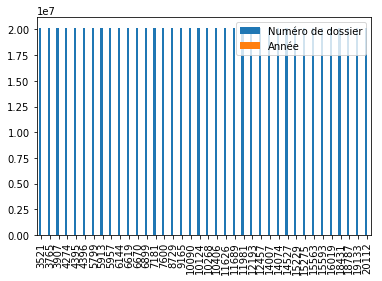

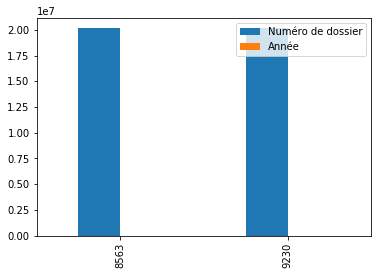

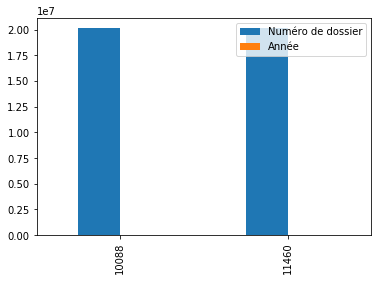

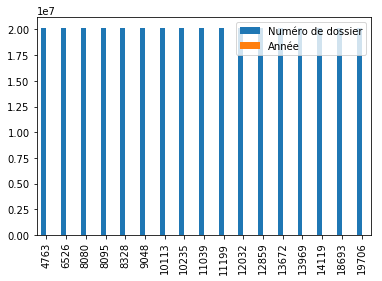

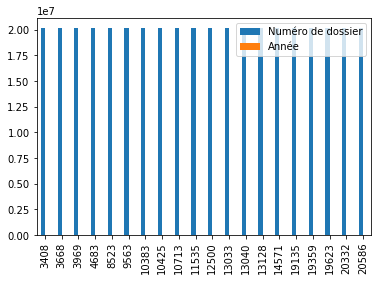

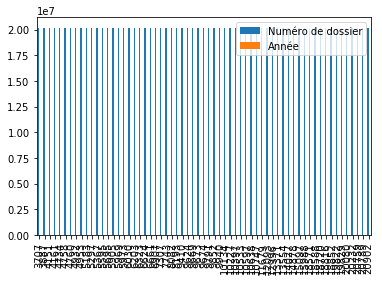

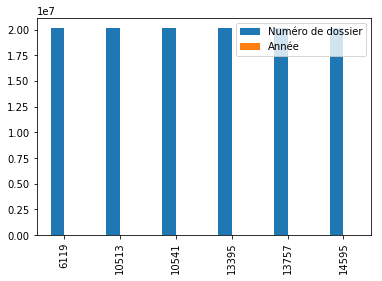

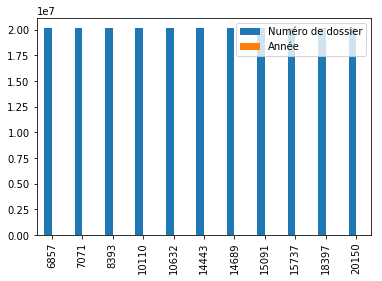

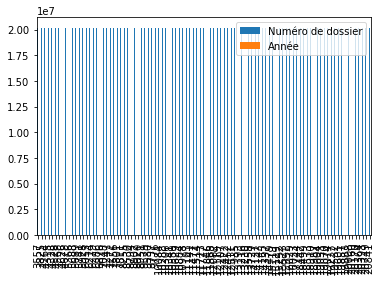

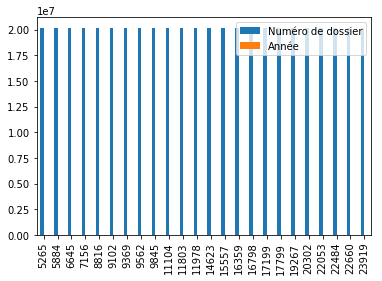

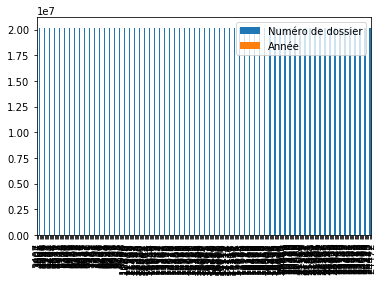

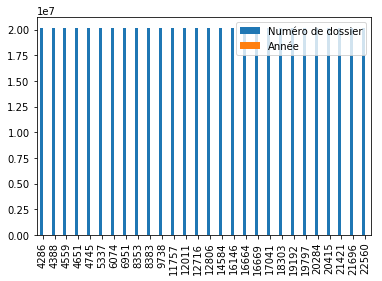

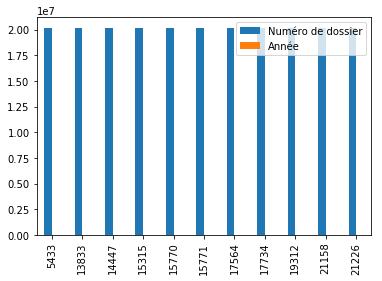

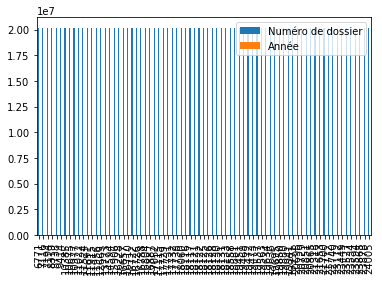

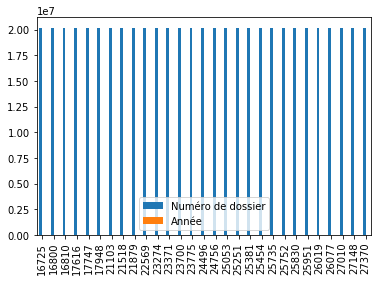

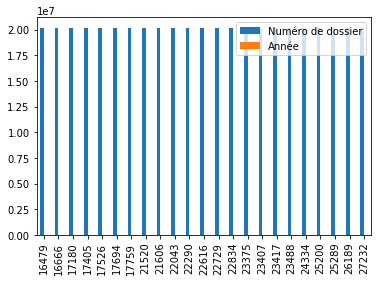

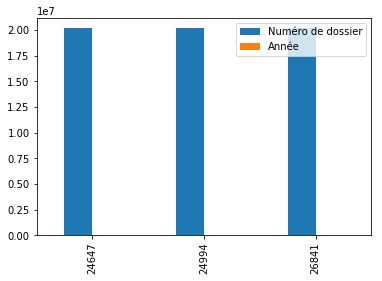

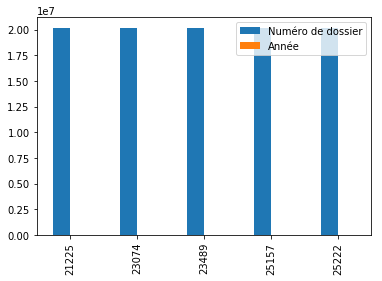

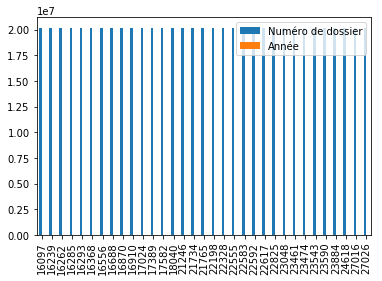

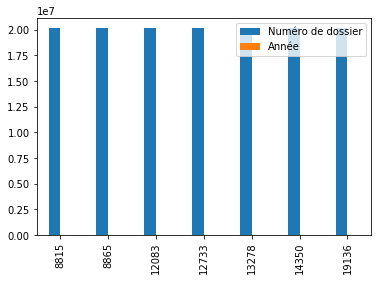

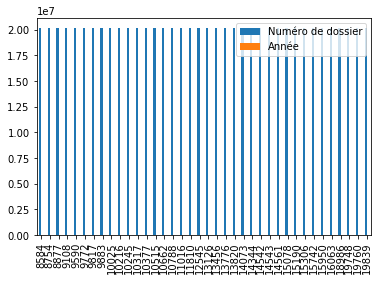

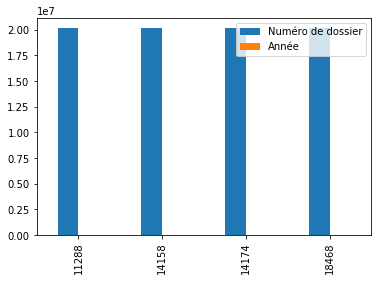

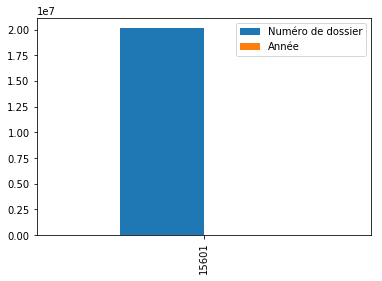

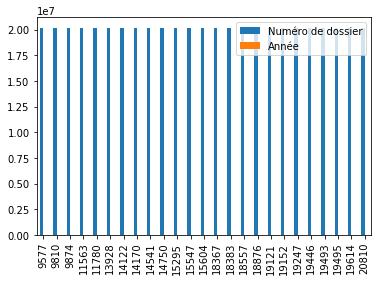

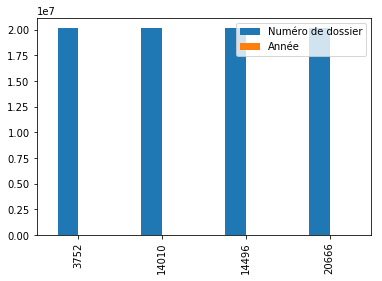

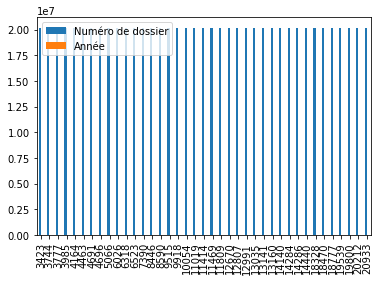

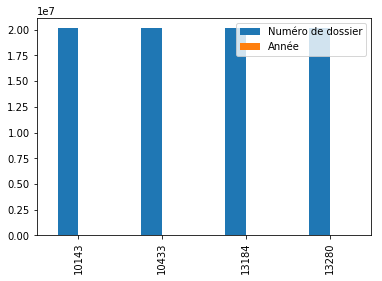

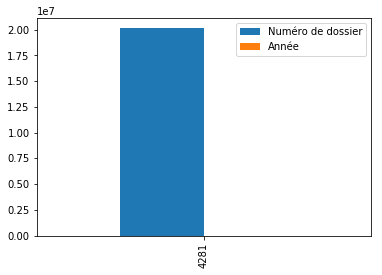

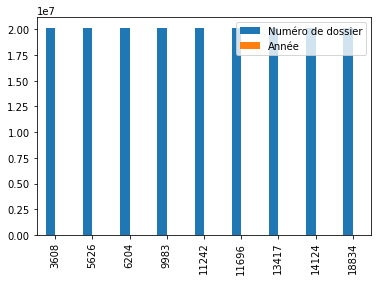

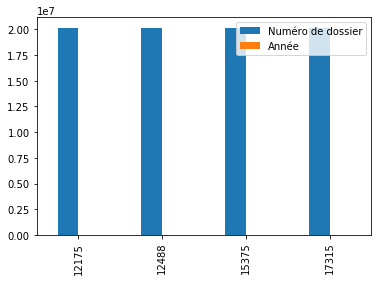

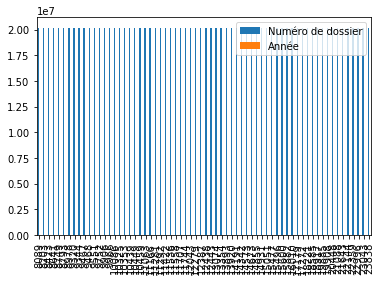

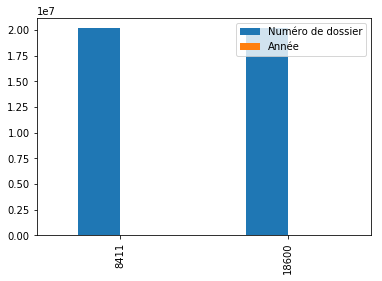

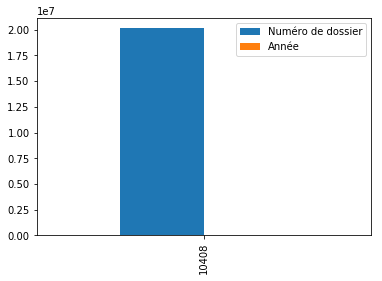

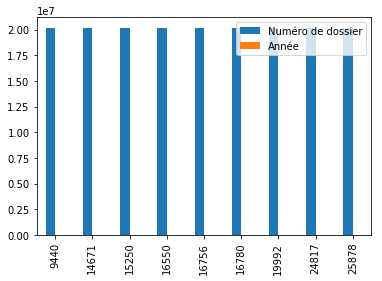

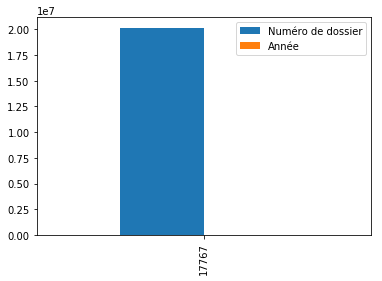

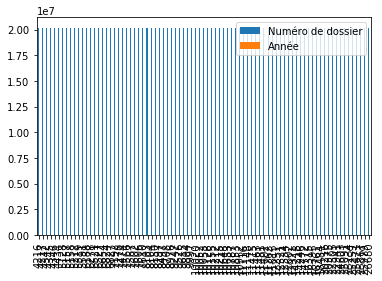

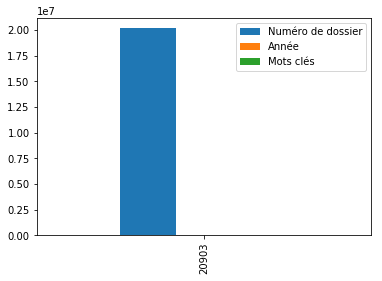

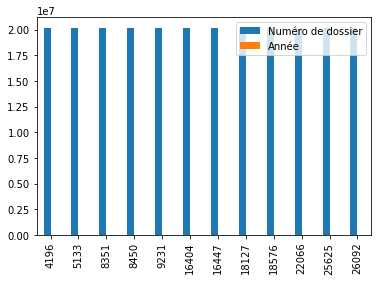

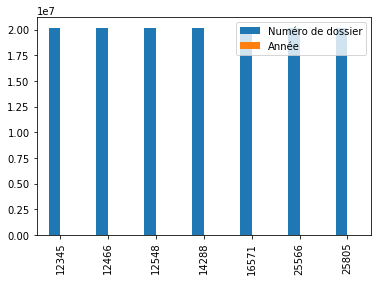

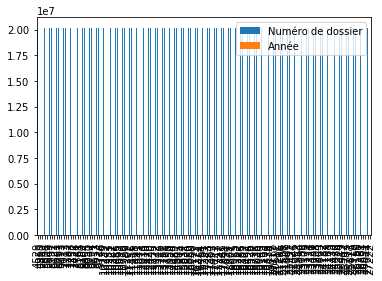

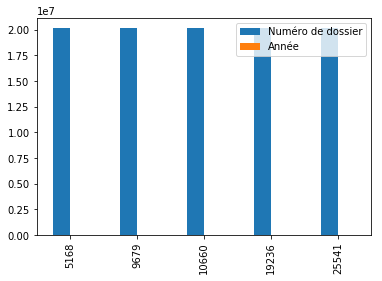

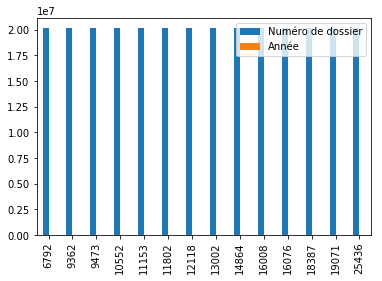

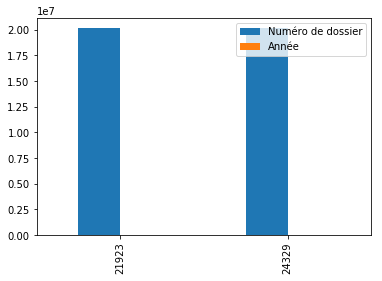

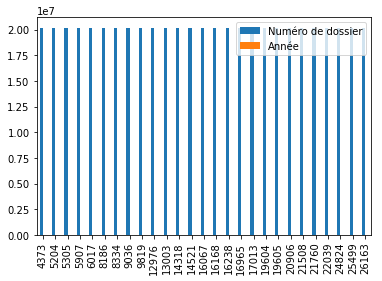

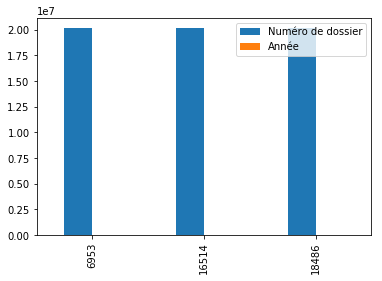

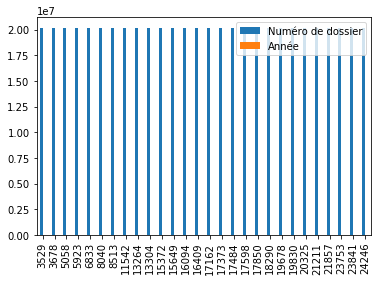

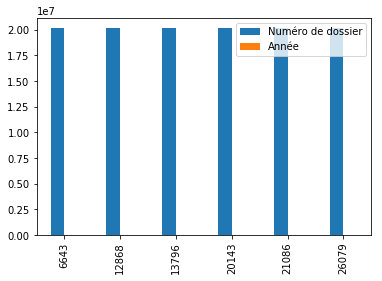

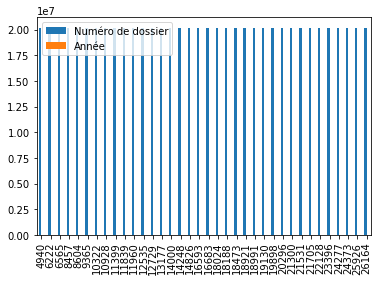

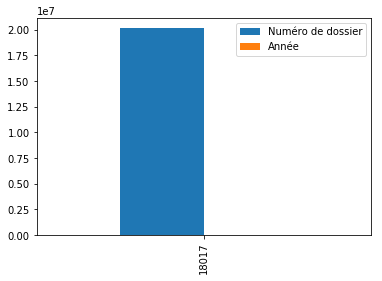

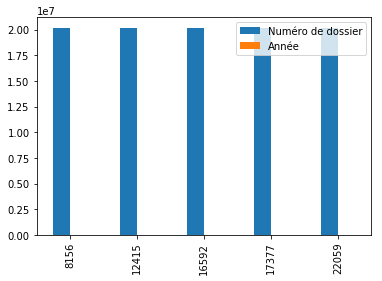

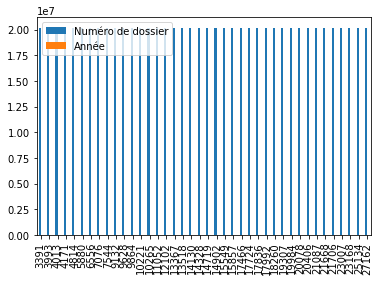

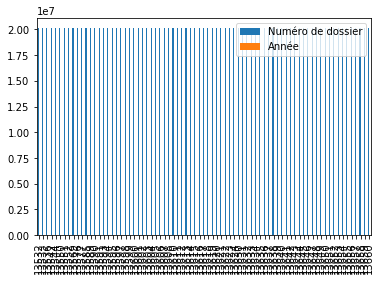

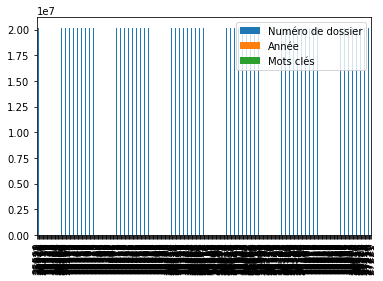

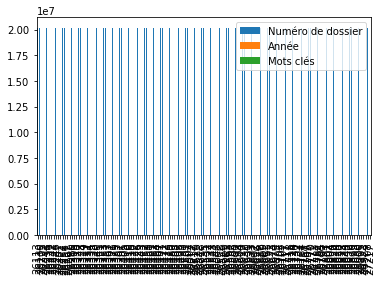

In [24]:
df_sup_50 = df.loc[df["Administration"].isin(sup_50)]
gp50 = df_sup_50.groupby(["Administration", "Sens_reduced"])
gp50.plot(kind="bar")

In [13]:
gp_admin_sens = df.groupby(["Administration", "Sens_reduced"])
#gp_admin_sens.plot(kind="bar")
foo = gp_admin_sens.groups.values()
list(foo)


[Int64Index([0, 415, 2488, 2590, 2821, 2989], dtype='int64'),
 Int64Index([1, 1030], dtype='int64'),
 Int64Index([2], dtype='int64'),
 Int64Index([3], dtype='int64'),
 Int64Index([4, 786], dtype='int64'),
 Int64Index([5], dtype='int64'),
 Int64Index([6, 1213, 2040], dtype='int64'),
 Int64Index([7, 18, 126, 1029, 2136], dtype='int64'),
 Int64Index([8], dtype='int64'),
 Int64Index([9], dtype='int64'),
 Int64Index([10], dtype='int64'),
 Int64Index([11], dtype='int64'),
 Int64Index([12], dtype='int64'),
 Int64Index([13], dtype='int64'),
 Int64Index([14], dtype='int64'),
 Int64Index([15], dtype='int64'),
 Int64Index([16], dtype='int64'),
 Int64Index([17], dtype='int64'),
 Int64Index([19], dtype='int64'),
 Int64Index([20], dtype='int64'),
 Int64Index([21], dtype='int64'),
 Int64Index([22], dtype='int64'),
 Int64Index([23, 175], dtype='int64'),
 Int64Index([24], dtype='int64'),
 Int64Index([25, 364, 1705], dtype='int64'),
 Int64Index([26], dtype='int64'),
 Int64Index([27], dtype='int64'),
 In

In [ ]:
gpb = df.groupby("Administration")

In [36]:
dict_gp = {}
for name, group in gpb:
    dict_gp[name] = len(group)
    

In [41]:
sorted(dict_gp.items(), key=lambda x: x[1], reverse=True)

[('Direction générale des finances publiques (DGFIP)', 885),
 ('X, député', 420),
 ("Ministère de l'intérieur", 406),
 ('Ministère de la justice', 406),
 ('Assistance Publique-Hôpitaux de Paris (AP-HP)', 300),
 ('Ministère de la défense', 197),
 ('Mairie de Paris', 192),
 ('Préfecture de police de Paris', 168),
 ('X, députée', 147),
 ('La Poste', 135),
 ('Ministère de la Justice', 106),
 ("Ministère de l'écologie, du développement durable et de l'énergie", 98),
 ('Préfecture de la Seine-Saint-Denis', 97),
 ('Ministère des Armées', 93),
 ('Pôle emploi', 88),
 ('Direction générale des patrimoines', 84),
 ('Orange Groupe', 82),
 ('Ministère de la culture et de la communication', 78),
 ("Service départemental d'incendie et de secours du Cher (SDIS 18)", 77),
 ('Ministère des affaires étrangères et du développement international', 75),
 ("Caisse primaire d'assurance maladie du Rhône (CPAM 69) ", 72),
 ('Mairie de Villeneuve-Saint-Georges', 63),
 ('Préfecture du Val-de-Marne', 60),
 ("Minist

In [ ]:
avis = df.